In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import glob
data_dir = "/content/drive/MyDrive/FaceMaskDataset"
home_dir = "/content/"

In [ ]:
#Downloading the dataset from Kaggle
requires_download = False
if requires_download:
  os.environ['KAGGLE_CONFIG_DIR'] = data_dir
  %cd $data_dir
  !kaggle datasets download -d andrewmvd/face-mask-detection --unzip 
  %cd $home_dir

In [ ]:
images = {}
def convert(size: tuple, box: list):
    """Takes as input:  (width, height) of an image
                        (xmin, ymin, xmax, ymax) of the bounding box
       and returns (x, y, w, h) of the bounding box in yolo format.
    """   
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[2] + box[0])/2.0
    y = (box[3] + box[1])/2.0
    w = abs(box[2] - box[0])
    h = abs(box[3] - box[1])
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh

    return (x, y, w, h)

def xml_to_txt(input_path: str, output_path: str):
    """Iterates through all .xml files (generated by labelImg) in the given directory,
    and generates .txt files that comply with yolo format for each .xml file.
    """ 
    class_mapping = {'with_mask' : '0',
                     'without_mask' : '1',
                     'mask_weared_incorrect' : '1'}

    if not glob.glob(input_path + '/*.xml'):
        raise(ValueError(f"Empty folder, there are no .xml files in {input_path}."))

    for xml_file in glob.glob(input_path + '/*.xml'):       
        tree = ET.parse(xml_file)
        root = tree.getroot()

        txt_list = []
        for member in root.findall("object"):
            f_name = root.find("filename").text
            width, height = int(root.find('size')[0].text), int(root.find("size")[1].text)
            c = member[0].text
            
            b = float(member[5][0].text), float(member[5][1].text), float(member[5][2].text), float(member[5][3].text)
            bb = convert((width, height), b)                     

            txt_list.append(class_mapping.get(c) + " " + " ".join([str(l) for l in bb]) + "\n")

        print(f"Building: {f_name.split('.')[0]}.txt")
        file_path = os.path.join(output_path, f_name.split(".")[0] + ".txt")
        with open(file_path, "w") as writer:
            for obj in txt_list:
                writer.write(obj)

In [ ]:
# newpath = r'/content/drive/MyDrive/FaceMaskDataset/YOLOv3' 
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# Convert data in xml format to txt format
xml_to_txt(data_dir + '/annotations', data_dir + '/images/')

In [ ]:
# files_in_directory = os.listdir('/content/drive/MyDrive/FaceMaskDataset/')
# filtered_files = [file for file in files_in_directory if file.endswith(".txt")]
# for file in filtered_files:
# 	path_to_file = os.path.join('/content/drive/MyDrive/FaceMaskDataset/', file)
# 	os.remove(path_to_file)

In [ ]:
# Get image filenames
images = []
for file in os.listdir('/content/drive/MyDrive/FaceMaskDataset/images/'):
    if file.endswith(".png"):
        images.append(file)

In [ ]:
len(images)

853

In [ ]:
# Check train and test size
train_size = int(len(images)*0.8)
test_size = len(images) - train_size
# train_images()

In [ ]:
import random
train_images = random.sample(images, train_size)
print(len(train_images))
val_images = []
for image in images:
  if image not in train_images: 
    val_images.append(image)
print(len(val_images))

682
171


In [ ]:
test_images = []
def is_image(file):
  return file.endswith(".png") or file.endswith(".jpg") or file.endswith("jpeg")
for file in os.listdir('/content/drive/MyDrive/FaceMaskDataset/TestImages/'):
    if is_image(file):
        test_images.append(file)
print(len(test_images))

40


In [ ]:
def generate_filenames_txt(files, isTrain = True):
    """
    Definition: Generate image paths for train or validation 
    and save it in a text file with the corresponding filename.

    files: The image names list
    isTrain(Bool): Whether the file list is for training or validation.
    """
    image_files = []
    for filename in files:
        image_files.append(data_dir + '/images/' + filename)
    file_path = ""
    if isTrain: file_path = data_dir + '/train.txt'
    else: file_path = data_dir + '/val.txt'
    with open(file_path, "w") as outfile:
        for image in image_files:
            outfile.write(image)
            outfile.write("\n")
        outfile.close()

def generate_test_filenames_txt(files):
    """
    Definition: Generate image paths for train or validation 
    and save it in a text file with the corresponding filename.

    files: The image names list
    isTrain(Bool): Whether the file list is for training or validation.
    """
    image_files = []
    for filename in files:
        image_files.append(data_dir + '/TestImages/' + filename)
    file_path = ""
    file_path = data_dir + '/test.txt'
    with open(file_path, "w") as outfile:
        for image in image_files:
            outfile.write(image)
            outfile.write("\n")
        outfile.close()

In [ ]:
# Generate the train and validation .txt files
# generate_filenames_txt(train_images, True)
# generate_filenames_txt(val_images, False)
generate_test_filenames_txt(test_images)

In [ ]:
%cd $home_dir

/content


In [ ]:
# Clone the repository to access the YOLOv3 model
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15376, done.
remote: Total 15376 (delta 0), reused 0 (delta 0), pack-reused 15376
Receiving objects: 100% (15376/15376), 14.01 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (10339/10339), done.


In [ ]:
# Copy 
import shutil
import os
%cd $home_dir
shutil.copy(data_dir + '/train.txt', home_dir + '/darknet/data/')
shutil.copy(data_dir + '/val.txt', home_dir + '/darknet/data/')
shutil.copy(data_dir + '/test.txt', home_dir + '/darknet/data/')
shutil.copy(data_dir + '/face_mask.data', home_dir + '/darknet/data/')
shutil.copy(data_dir + '/face_mask_test.data', home_dir + '/darknet/data/')
shutil.copy(data_dir + '/face_mask.names', home_dir + '/darknet/data/') 
shutil.copy(data_dir + '/face_mask.cfg', home_dir + '/darknet/cfg/')

/content


'/content//darknet/cfg/face_mask.cfg'

In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make
!chmod +x ./darknet

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

In [ ]:
loadPretrainedWeights = True

weights_file = ''
if load loadPretrainedWeights:
  if not os.path.exists('darknet53.conv.74'):
    !wget http://pjreddie.com/media/files/darknet53.conv.74
    weights_file = 'darknet53.conv.74'
else:
  weights_file = data_dir + '/backup/face_mask_best.weights'
!./darknet detector train data/face_mask.data cfg/face_mask.cfg $weights_file -map -dont_show | tee log.txt

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.028752, iou_loss = 0.000000, total_loss = 0.028752 
 total_bbox = 214697, rewritten_bbox = 0.067537 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.805502), count: 1, class_loss = 0.000009, iou_loss = 0.028426, total_loss = 0.028435 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.853792), count: 5, class_loss = 0.042907, iou_loss = 0.084136, total_loss = 0.127043 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.837906), count: 1, class_loss = 0.001341, iou_loss = 0.023589, total_loss = 0.024930 
 total_bbox = 214704, rewritten_bbox = 0.067535 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.822765), count: 3, class_loss = 0.000177, iou_loss = 0.059249, total_loss = 0.059425 
v3 (m

In [ ]:
#Validation metrics
weights_file = data_dir + '/backup/face_mask_best.weights'
!./darknet detector map data/face_mask.data cfg/face_mask.cfg $weights_file -points 11

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

In [ ]:
#Test set metrics
!./darknet detector map data/face_mask_test.data cfg/face_mask.cfg $weights_file -points 11

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# define helper functions
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def plot_test_images(path, weights = data_dir + '/backup/face_mask_best.weights'):
  num_images = len(os.listdir(path))
  fig = plt.figure(figsize=(18, 10*num_images))
  image_path = ""
  for index, img in enumerate(os.listdir(path)):
    image_path = path + img
    !./darknet detector test data/face_mask.data cfg/face_mask.cfg $weights $image_path
    shutil.copy('predictions.jpg', data_dir + '/predictions/prediction{}.jpg'.format(index+1))
    image = cv2.imread('predictions.jpg')
    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
    fig.add_subplot(num_images, 1, index+1)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

def imShow(path, ax):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  # fig = plt.gcf()
  # fig.set_size_inches(18, 10)
  plt.axis("off")
  ax.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

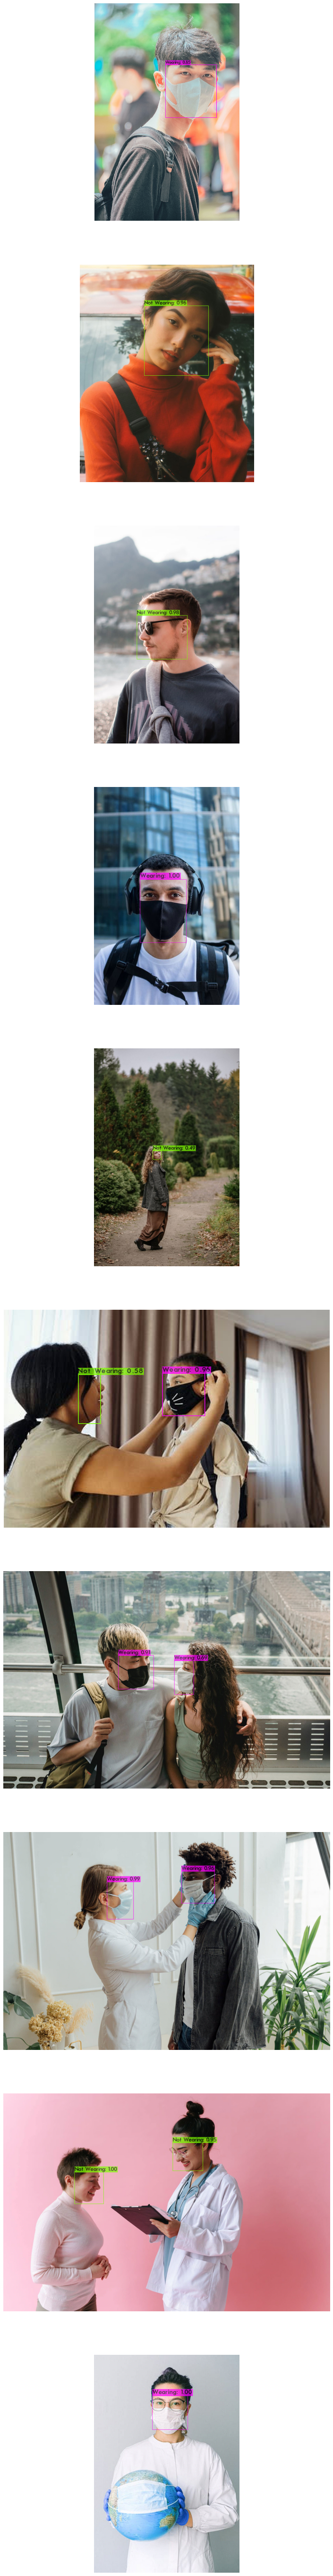

In [ ]:
plot_test_images(data_dir + '/testImages/')

In [ ]:
test_img = '/content/drive/MyDrive/FaceMaskDataset/testImages/0_commuters1.jpg'
!./darknet detector test data/face_mask_test.data cfg/face_mask.cfg /content/drive/MyDrive/FaceMaskDataset/backup/face_mask_best.weights $test_img

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

In [ ]:
#Write test.txt file
# def generate_test_filenames(files):
#     """
#     Definition: Generate image paths for test 
#     and save it in a text file with the corresponding filename.

#     files: The image names list
#     """
#     image_files = []
#     for filename in files:
#         image_files.append('/content/drive/MyDrive/FaceMaskDataset/testImages/' + filename)
#     file_path = '/content/drive/MyDrive/FaceMaskDataset/' + 'test.txt'
#     with open(file_path, "w") as outfile:
#         for image in image_files:
#             outfile.write(image)
#             outfile.write("\n")
#         outfile.close()

In [ ]:
test_img = '/content/drive/MyDrive/FaceMaskDataset/TestImages/RJB11658129.jpg'
weights_file = data_dir + '/backup/face_mask_best.weights'
!./darknet detector test data/face_mask_test.data cfg/face_mask.cfg $weights_file $test_img

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,